# Neural Network Notebook

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

## Requirements / General Notes:
#### - Try Different Feature Transformations (PCA, ... etc.)
#### - Try Different Model Architecutres (Going to try 3 different model architectures)
#### - Try Different Regulariztions (6 Different values for each model)
#### - Different sybmol ID represent different securities
#### - Time series data, so Date ID is important

In [2]:
# configs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Data Imports (Data Already Scaled & Normalized Thanks MJ :) )

In [34]:
train_val_df = pd.read_csv('/content/df_miss_outliers_replaced_scaled_normalized.csv')
test_df = pd.read_csv('/content/df_test_scaled_normalized.csv')

## Data preparation for training and validation

In [40]:

#Splitting features and targets
train_val_features = train_val_df[[f"feature_{i:02}" for i in range(79)]].values
train_val_target = train_val_df['responder_6'].values

#Converting them into torch tensors
X_tensor = torch.tensor(train_val_features, dtype=torch.float32)
y_tensor = torch.tensor(train_val_target, dtype=torch.float32).unsqueeze(1)

### Custom Dataset Class
#### Was having issues with using X and y as pure torchTesnors, so I created a custom dataset class

In [41]:
class TimeSeriesDataset(Dataset): #Took a minute, but apparently it must inherit from the PyTorch "Abstract Dataset Class"
    def __init__(self, features, target):
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

dataset = TimeSeriesDataset(X_tensor, y_tensor)

train_ratio = 0.8  # 80% for training, 20% for validation
train_size = int(len(dataset) * train_ratio)
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) #Splits the data dandomly

# Using Pytorch DataLoaders - It is a must for using PyToech
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Printing dataset sizes
print("Total dataset size: ", len(dataset))
print("Training dataset size: ", len(train_dataset))
print("Validation dataset size: len(val_dataset)", len(val_dataset))

for batch in train_loader:
    inputs, targets = batch
    print("Training batch - Inputs:", inputs.shape, "Targets:", targets.shape)
    break

for batch in val_loader:
    inputs, targets = batch
    print("Validation batch - Inputs:", inputs.shape, "Targets:", targets.shape)
    break

Total dataset size:  471486
Training dataset size:  377188
Validation dataset size: len(val_dataset) 94298
Training batch - Inputs: torch.Size([32, 79]) Targets: torch.Size([32, 1])
Validation batch - Inputs: torch.Size([32, 79]) Targets: torch.Size([32, 1])


## 3 different Multi-Layer Perceptrons
Reference: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

### Standard MLP
#### 2 hidden layers:
* 1st hidden layer: 128 neurons
* 2nd hidden layer: 64 neurons

In [42]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units=[128, 64], output_dim=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units[0])
        self.fc2 = nn.Linear(hidden_units[0], hidden_units[1])
        self.fc3 = nn.Linear(hidden_units[1], output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
input_dim = train_val_features.shape[1]  # Number of features
standard_model = MLP(input_dim)

### Wider MLP
#### 2 hidden layers:
* 1st hidden layer: 512 neurons
* 2nd hidden layer: 256 neurons

In [43]:
class WiderMLP(nn.Module):
    def __init__(self, input_dim, hidden_units=[512, 256], output_dim=1):
        super(WiderMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units[0])
        self.fc2 = nn.Linear(hidden_units[0], hidden_units[1])
        self.fc3 = nn.Linear(hidden_units[1], output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        return x

input_dim = train_val_features.shape[1]  # Number of features
wider_model = WiderMLP(input_dim)

### Deeper MLP
#### 4 hidden layers:
* 1st hidden layer: 128 neurons
* 2nd hidden layer: 128 neurons
* 3rd hidden layer: 64 neurons
* 4th hidden layer: 64 neurons


In [44]:
class DeeperMLP(nn.Module):
    def __init__(self, input_dim, hidden_units=[128, 128, 64, 64], output_dim=1):
        super(DeeperMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units[0])
        self.fc2 = nn.Linear(hidden_units[0], hidden_units[1])
        self.fc3 = nn.Linear(hidden_units[1], hidden_units[2])
        self.fc4 = nn.Linear(hidden_units[2], hidden_units[3])
        self.fc5 = nn.Linear(hidden_units[3], output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

input_dim = train_val_features.shape[1]  # Number of features
deeper_model = DeeperMLP(input_dim)

## Model Training

Reference: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [52]:
%%time


#Keeping lr=0.001 constant for each of the networks.

def train_model(num_epochs, data_loader, lambda_, model, losses):

    #Opting for a the adam optimizer, may switch it up, depending on time constraints
    #Also, going with the Mean-Squard error for measuring loss

    optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=lambda_)
    criterion = nn.MSELoss()

    # losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in data_loader:
            inputs, targets = batch

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(data_loader):.4f}")
        losses.append(running_loss/len(data_loader))


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


In [53]:
num_epochs = 5
lambda_ = 1e-4
losses = []
train_model(num_epochs, train_loader, lambda_, standard_model, losses)

Epoch [1/5], Loss: 0.7920
Epoch [2/5], Loss: 0.7920
Epoch [3/5], Loss: 0.7917
Epoch [4/5], Loss: 0.7916
Epoch [5/5], Loss: 0.7915


## Model Evaluation

In [47]:

def evaluate_model(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    targets = []
    total_loss = 0.0

    with torch.no_grad():  # Disabling gradent calculation
        for inputs, labels in dataloader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Store predictions and targets
            predictions.append(outputs.numpy())
            targets.append(labels.numpy())


    # Combine all predictions and targets
    predictions = np.vstack(predictions)
    targets = np.vstack(targets)

    # Metrics for calculated on the validation set
    mse = mean_squared_error(targets, predictions)  # Mean-Squared Error
    mae = mean_absolute_error(targets, predictions) # Mean-Aboslute Error
    r2 = r2_score(targets, predictions)             # R2 Score

    # Average loss
    avg_loss = total_loss / len(dataloader)

    metrics = {
        "Loss (MSE)": avg_loss,
        "Mean Squared Error": mse,
        "Mean Absolute Error": mae,
        "R2 Score": r2,
    }

    return metrics, predictions, targets

criterion = torch.nn.MSELoss()

metrics, predictions, targets = evaluate_model(standard_model, val_loader, criterion)

print("Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Evaluation Metrics:
Loss (MSE): 0.8012
Mean Squared Error: 0.8013
Mean Absolute Error: 0.5760
R2 Score: 0.0008


## Training Loss and Epochs Graph

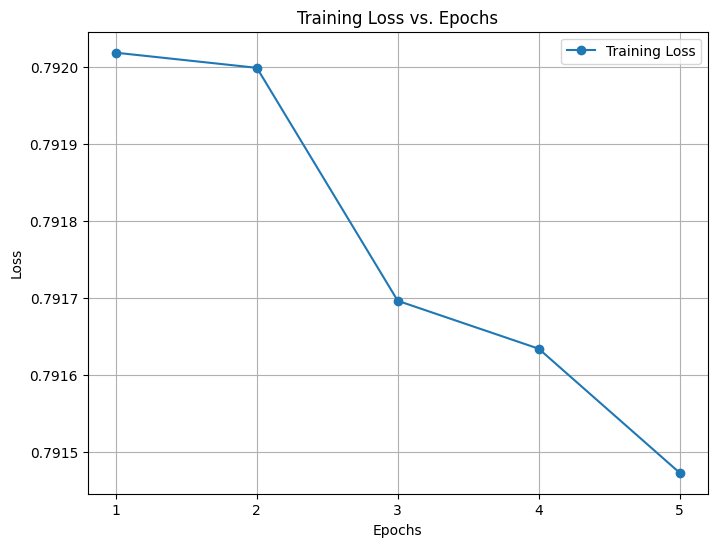

In [54]:

def plot_training_loss(losses, title="Training Loss vs. Epochs"):

    epochs = range(1, len(losses) + 1)  # Epoch numbers (1-based index)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, losses, marker='o', label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(epochs)  # Set x-axis ticks to correspond to each epoch
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


plot_training_loss(losses)

#### I will run all of the tests tomorrow. This is set up nicely. Should take like 10 minutes, or more depending on how daunting the training is.

In [55]:
num_epochs = 5
lambda_ = 1e-4
losses = []
train_model(num_epochs, train_loader, lambda_, wider_model, losses)

Epoch [1/5], Loss: 0.7934
Epoch [2/5], Loss: 0.7934
Epoch [3/5], Loss: 0.7934
Epoch [4/5], Loss: 0.7934
Epoch [5/5], Loss: 0.7933


In [57]:

criterion = torch.nn.MSELoss()

metrics, predictions, targets = evaluate_model(wider_model, val_loader, criterion)

print("Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Evaluation Metrics:
Loss (MSE): 0.8019
Mean Squared Error: 0.8019
Mean Absolute Error: 0.5765
R2 Score: -0.0000


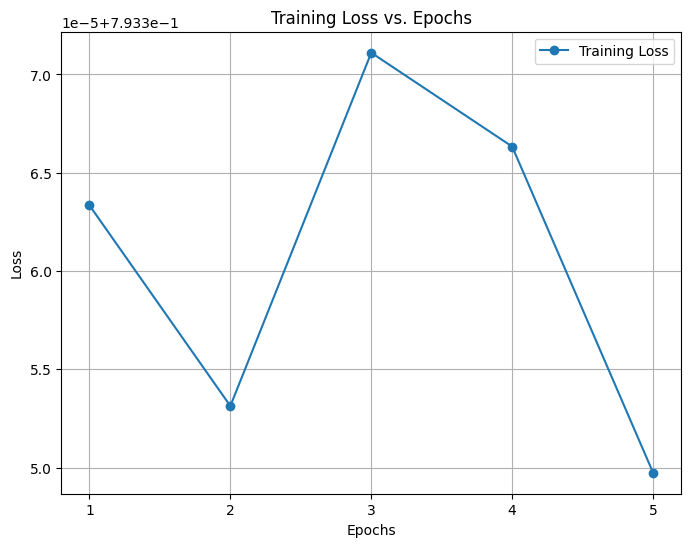

In [56]:

plot_training_loss(losses)

In [58]:
num_epochs = 5
lambda_ = 1e-4
losses = []
train_model(num_epochs, train_loader, lambda_, deeper_model, losses)

Epoch [1/5], Loss: 0.7935
Epoch [2/5], Loss: 0.7934
Epoch [3/5], Loss: 0.7935
Epoch [4/5], Loss: 0.7935
Epoch [5/5], Loss: 0.7934


In [59]:
criterion = torch.nn.MSELoss()

metrics, predictions, targets = evaluate_model(deeper_model, val_loader, criterion)

print("Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Evaluation Metrics:
Loss (MSE): 0.8021
Mean Squared Error: 0.8022
Mean Absolute Error: 0.5761
R2 Score: -0.0003


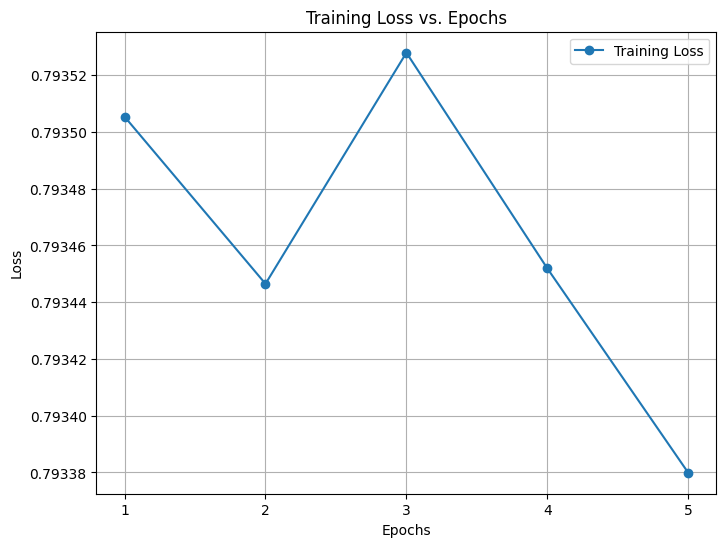

In [60]:

plot_training_loss(losses)